## **Lab 2 | Handwritten Digit Recognition System**

Problem Statement
- Developing a handwritten digital recognition system by creating a neural network model trained on MNIST dataset "handwritten digits from 0 to 9"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Step 1: [Loading MNIST dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)**

In [35]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

print(train_data.head())

print("\nTrain Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)


**Dataset description:**
 - The MNIST dataset contains grayscale images of digits along with their corresponding labels.
 - Each image is 28x28 pixels, flattened into a vector of size 784.
 - The labels range from 0 to 9.

#### *Checking dataset distribution*

In [ ]:
print("\nTrain Data Distribution:")
print(train_data.iloc[:, 0].value_counts())

print("\nTest Data Distribution:")
print(test_data.iloc[:, 0].value_counts())


Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)

Train Data Distribution:
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Test Data Distribution:
label
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


**Conclusion**: the distribution is well balanced, no label is significantly overrepresented, or underrepresented, which minimizes bias towards a specific label

### **Step 2: Data Splitting**

In [5]:
X_temp = train_data.iloc[:,1:].values
y_temp = train_data.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [6]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50000
Validation set size: 10000
Test set size: 10000


#### *Normalization*
 dividing by 255, so that ranges are [0,1], ensuring numerical stability during training

In [7]:
X_test = X_test / 255.0
X_train = X_train / 255.0
X_val = X_val / 255.0

Visual representation of a random sample

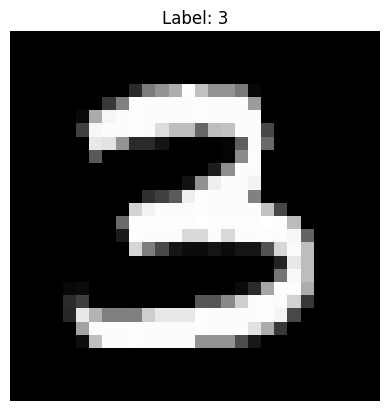

In [10]:
sample_image = X_train[10]
sample_label = y_train[10]
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### **Step 3: Converting Data to Tensors**

In [11]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### **Step 4: Data Loaders** to facilitate batch processing

In [12]:
batch_size = 32

# Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Step 5: Neural Network Design**
Fully connected feedforward neural network with:
- Input layer: 784 neurons, one for each pixel
- 2 hidden layers: 128 neurons in the first, and 64 neurons in the second
- Output layer: 10 neurons, one for each class
- activation function: ReLU

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [14]:
model = FeedforwardNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### **Step 6: Training the model**

In [15]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):

      # Training Loss and Accuracy
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct / total

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation Loss and Accuracy
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      for inputs, labels in val_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * val_correct / val_total

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{epochs}]')
      print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
      print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

  # Plot the training loss
  plt.figure(figsize=(12, 10))

  # Plot loss
  plt.subplot(2, 2, 1)  # Training Loss
  plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)  # Validation Loss
  plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plot accuracy
  plt.subplot(2, 2, 3)  # Training Accuracy
  plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(2, 2, 4)  # Validation Accuracy
  plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  # Show the plots
  plt.tight_layout()
  plt.show()

Epoch [1/10]
Training Loss: 1.3262, Accuracy: 69.68%
Validation Loss: 0.4874, Accuracy: 86.52%
Epoch [2/10]
Training Loss: 0.3903, Accuracy: 88.87%
Validation Loss: 0.3415, Accuracy: 90.40%
Epoch [3/10]
Training Loss: 0.3123, Accuracy: 91.04%
Validation Loss: 0.2905, Accuracy: 91.83%
Epoch [4/10]
Training Loss: 0.2712, Accuracy: 92.25%
Validation Loss: 0.2566, Accuracy: 92.58%
Epoch [5/10]
Training Loss: 0.2405, Accuracy: 93.06%
Validation Loss: 0.2299, Accuracy: 93.50%
Epoch [6/10]
Training Loss: 0.2164, Accuracy: 93.81%
Validation Loss: 0.2081, Accuracy: 94.05%
Epoch [7/10]
Training Loss: 0.1952, Accuracy: 94.39%
Validation Loss: 0.1896, Accuracy: 94.59%
Epoch [8/10]
Training Loss: 0.1786, Accuracy: 94.80%
Validation Loss: 0.1740, Accuracy: 95.06%
Epoch [9/10]
Training Loss: 0.1633, Accuracy: 95.26%
Validation Loss: 0.1602, Accuracy: 95.55%
Epoch [10/10]
Training Loss: 0.1502, Accuracy: 95.66%
Validation Loss: 0.1482, Accuracy: 95.88%


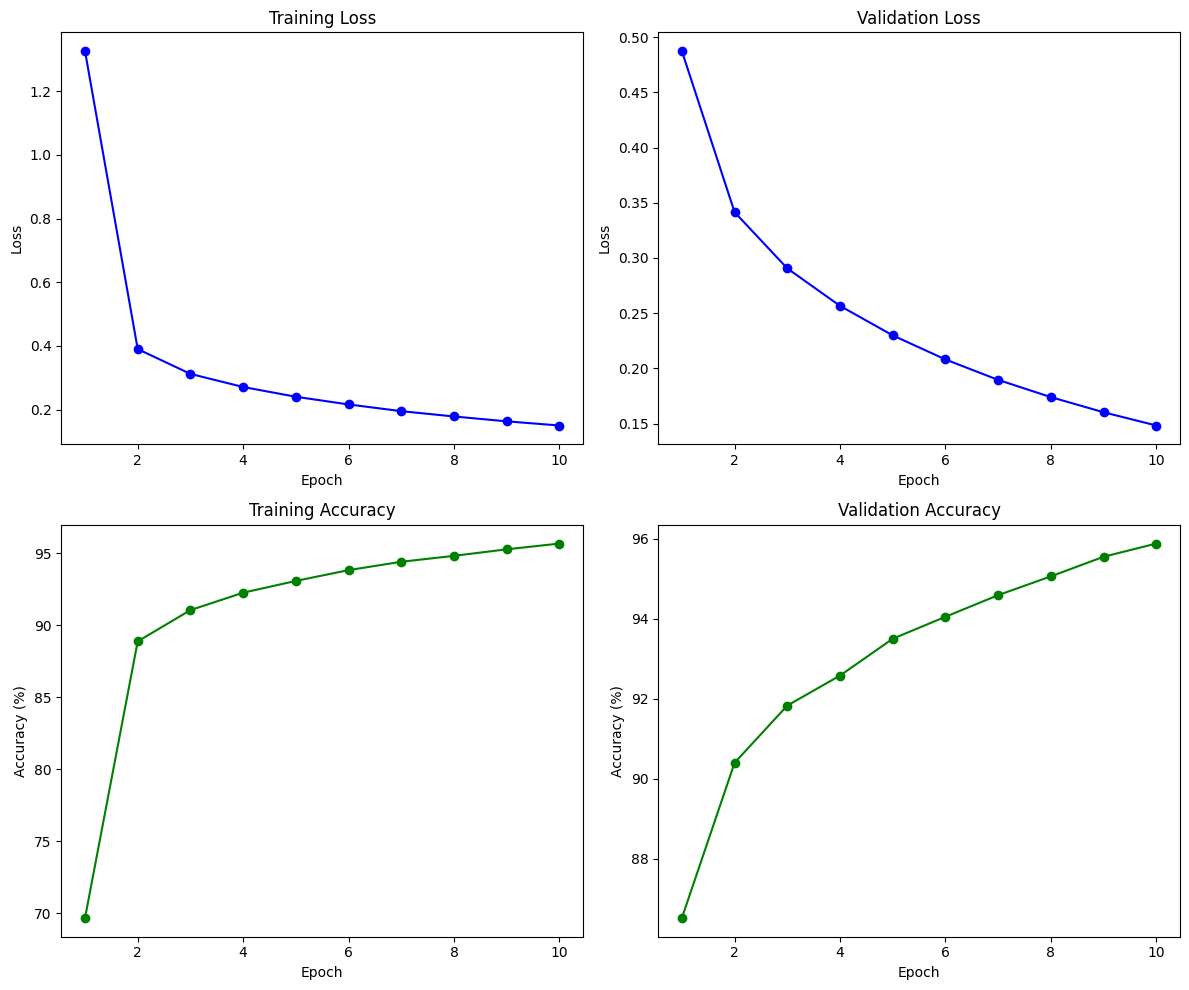

In [16]:
train(model, train_loader, val_loader, loss_fn, optimizer, 10)

*Conclusion*
After 10 epochs:
 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%


### **Step 7: Testing the model**

In [ ]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  # Storing all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Reshaping inputs
          inputs = inputs.view(inputs.size(0), -1)  # Automatically handle batch size
          outputs = model(inputs)

          # Get predicted labels
          _, predicted = torch.max(outputs, dim=1)

          # Update metrics
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store predictions and true labels
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate overall accuracy
  test_accuracy = 100 * correct / total
  print(f"Test Accuracy: {test_accuracy:.2f}%")


  cm = confusion_matrix(all_labels, all_preds)

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  ################################

  # Visualize multiple sample predictions
  sample_indices = [0,1,2,3,4,5]

  num_samples = len(sample_indices)
  plt.figure(figsize=(12, 3 * num_samples))

  for i, index in enumerate(sample_indices):
      sample_image = X_test[index]
      true_label = y_test[index]

      # Prepare the sample for the model
      sample_image = torch.tensor(sample_image).float().view(1, -1)

      with torch.no_grad():
          output = model(sample_image)
          _, predicted_label = torch.max(output, 1)

      # Plot the image
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(sample_image.reshape(28, 28), cmap='gray')
      plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

Test Accuracy: 95.57%


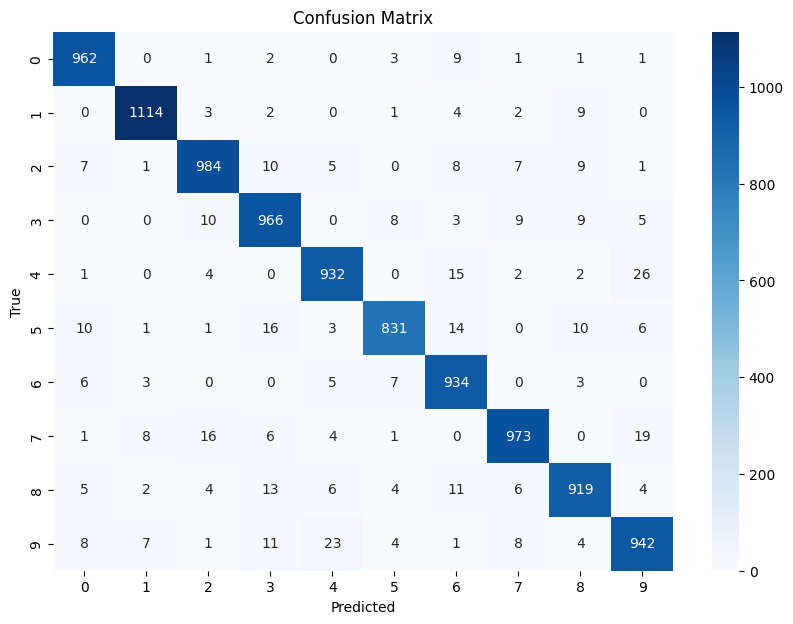

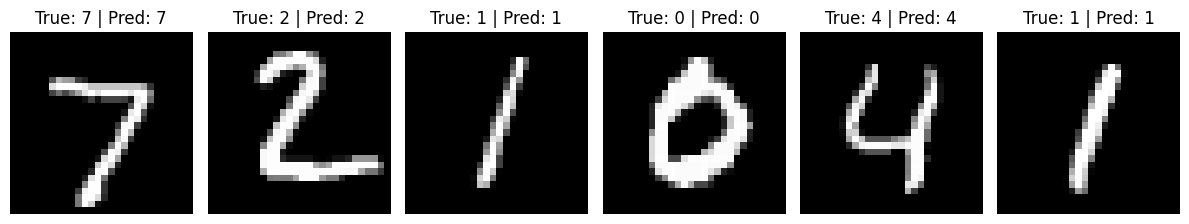

In [30]:
test(model, test_loader)

### **Summary:**

 - Training Accuracy = 95.66%
 - Validation Accuracy = 95.88%
 - Test Accuracy = 95.57%